# Realization of Recursive Filters

*This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Digital Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).*

## Direct Form Structures

The output signal $y[k] = \mathcal{H} \{ x[k] \}$ of a recursive linear-time invariant (LTI) system is given by

\begin{equation}
y[k] = \frac{1}{a_0} \left( \sum_{m=0}^{M} b_m \; x[k-m] - \sum_{n=1}^{N} a_n \; y[k-n] \right)
\end{equation}

where $a_n$ and $b_m$ denote constant coefficients and $N$ the order. Note that systems with $M > N$ are in general not stable. The computational realization of above equation requires additions, multiplications, the actual and past samples of the input signal $x[k]$, and the past samples of the output signal $y[k]$. Technically this can be realized by

* adders
* multipliers, and
* unit delays or storage elements.

These can be arranged in different topologies. A certain class of structures, which is introduced in the following, is known as *direct form structures*. Other known forms are for instance [cascaded sections](cascaded_structures.ipynb), parallel sections, lattice structures and state-space structures.

For the following it is assumed that $a_0 = 1$. This can be achieved for instance by dividing the remaining coefficients by $a_0$.

### Direct Form I

The [direct form I](https://en.wikipedia.org/wiki/Digital_filter#Direct_Form_I) is derived by rearranging above equation for $a_0 = 1$

\begin{equation}
y[k] = \sum_{m=0}^{M} b_m \; x[k-m] + \sum_{n=1}^{N} - a_n \; y[k-n]
\end{equation}

It is now evident that we can realize the recursive filter by a superposition of a non-recursive and a recursive part. With the elements given above, this results in the following block-diagram

![Direct form I filter](direct_form_i.png)

This representation is not canonical since $N + M$ unit delays are required to realize a system of order $N$. A benefit of the direct form I is that there is essentially only one summation point which has to be taken care of when considering quantized variables and overflow. The output signal $y[k]$ for the direct form I is computed by realizing above equation.

The block diagram of the direct form I can be interpreted as the cascade of two systems. Denoting the signal in between both as $w[k]$ and discarding initial values we get

\begin{align}
w[k] &= \sum_{m=0}^{M} b_m \; x[k-m] = h_1[k] * x[k] \\
y[k] &= w[k] + \sum_{n=1}^{N} - a_n \; w[k-n] = h_2[k] * w[k] = h_2[k] * h_1[k] * x[k]
\end{align}

where $h_1[k] = [b_0, b_1, \dots, b_M]$ denotes the impulse response of the non-recursive part and $h_2[k] = [1, -a_1, \dots, -a_N]$ for the recursive part. From the last equality of the second equation and the commutativity of the convolution it becomes clear that the order of the cascade can be exchanged.

### Direct Form II

The [direct form II](https://en.wikipedia.org/wiki/Digital_filter#Direct_Form_II) is yielded by exchanging the two systems in above block diagram and noticing that there are two parallel columns of delays which can be combined, since they are redundant. For $N=M$ it is given as

![Direct form II filter](direct_form_ii.png)

Other cases with $N \neq M$ can be considered for by setting coefficients to zero. This form is a canonical structure since it only requires $N$ unit delays for a recursive filter of order $N$. The output signal $y[k]$ for the direct form II is computed by the following equations

\begin{align}
w[k] &= x[k] + \sum_{n=1}^{N} - a_n \; w[k-n] \\
y[k] &= \sum_{m=0}^{M} b_m \; w[k-m]
\end{align}

The samples $w[k-m]$ are termed *state* (variables) of a digital filter.

### Transposed Direct Form II

The block diagrams above can be interpreted as linear [signal flow graphs](https://en.wikipedia.org/wiki/Signal-flow_graph). The theory of these graphs provides useful transformations into different forms which preserve the overall transfer function. Of special interest is the *transposition* or *reversal* of a graph which can be achieved by

* exchanging in- and output,
* exchanging signal split and summation points, and
* reversing the directions of the signal flows.

Applying this procedure to the direct form II shown above for $N=M$ yields the transposed direct form II

![Transposed direct form II filter](direct_form_ii_t.png)

The output signal of the transposed direct form II is given as

\begin{equation}
y[k] = b_0 x[k] + \sum_{m=1}^{M} b_m x[k-n] - \sum_{n=1}^{N} a_n y[k-n]
\end{equation}

Using the signal before the $n$-th delay unit as internal state $w_n[k]$ we can reformulate this into a set of difference equations for computation of the output signal

\begin{align}
w_n[k] &= 
\begin{cases}
w_{n+1}[k-1] - a_n y[k] + b_n x[k] & \text{for } n=0,1,\dots,N-1 \\
-a_N y[k]  + b_N x[k] & \text{for } n=N
\end{cases}\\
y[k] &= w_1[k-1] + b_0 x[k]
\end{align}

#### Example - Computation of output signal

The following example illustrates the computation of the impulse response $h[k]$ of a 2nd-order recursive system using the transposed direct form II as realized by `scipy.signal.lfilter`.

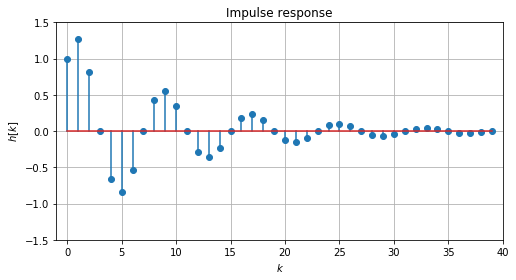

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

p = 0.90*np.exp(-1j*np.pi/4)
a = np.poly([p, np.conj(p)])  # denominator coefficients
b = [1, 0, 0]  # numerator coefficients
N = 40  # number of computed samples

# generate input signal (= Dirac impulse)
k = np.arange(N)
x = np.where(k==0, 1.0, 0.0)

# filter signal using transposed direct form II
h = sig.lfilter(b, a, x)

# plot output signal
plt.figure(figsize=(8, 4))
plt.stem(h)
plt.title('Impulse response')
plt.xlabel(r'$k$')
plt.ylabel(r'$h[k]$')
plt.axis([-1, N, -1.5, 1.5])
plt.grid()

**Exercise**

* Compute the step-response $h_\epsilon[k] = \mathcal{H} \{ \epsilon[k] \}$ of the filter by modifying above example.

Solution: The step response can be computed by changing the input signal to 

```python
x = np.where(k>=0, 1.0, 0.0)
``` 

or by cumulative summation of the impulse response due to the relation $h_\epsilon[k] = \sum_{\kappa =0}^k h[k]$ of the step response to the impulse response

```python
he = np.cumsum(h)
```

**Copyright**

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Sascha Spors, Digital Signal Processing - Lecture notes featuring computational examples, 2016-2018*.